In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random 
import heapq

# df = pd.read_csv('top_1000_by_liquidity.csv')
# df_cropped = df[['token0.symbol', 'token1.symbol','reserveUSD']]
# G = nx.from_pandas_edgelist(df_cropped, source='token0.symbol', target='token1.symbol', edge_attr='reserveUSD', create_using=nx.Graph().to_undirected())


In [2]:
# G.number_of_nodes()

In [3]:
# nx.draw_spring(G, with_labels=False, node_size=5, width=1)

In [4]:
def build_graph():
    df = pd.read_csv('top_1000_by_liquidity.csv')
    df_cropped = df[['token0.symbol', 'token1.symbol','reserveUSD']]
    G = nx.from_pandas_edgelist(df, source='token0.symbol', target='token1.symbol', edge_attr='reserveUSD', create_using=nx.Graph().to_undirected())
    return G

In [5]:
def draw_graph(G):
    plt.title("UniSwap token pair liquidity")
    nx.draw_spring(G, with_labels=False, node_size=5, width=1)
    #plt.close()

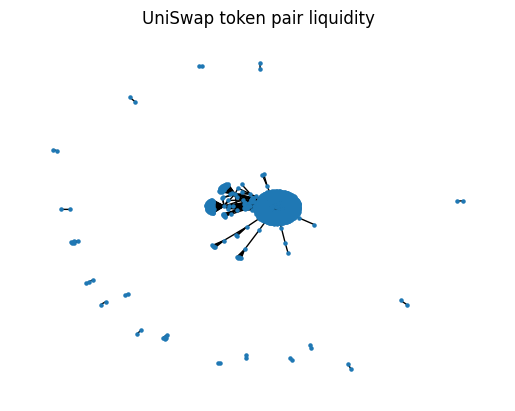

In [6]:
G = build_graph()
draw_graph(G)

In [7]:
def remove_node_randomly(G, num):
    g_rem = G.copy()
    #nodes_to_be_removed = random.sample(range(0, 934), num)
    nodes_g = list(g_rem.nodes) # list of all the tokens in the graph 
    ran_sample = random.sample(nodes_g, num)    # randomly selectes specified number of token from the graph
    g_rem.remove_nodes_from(ran_sample) # remove the randomlu selected tokens from the graph
    
    return g_rem


In [8]:
def remove_most_important_nodes(G, num, centrality_measure):
    g_rem = G.copy()
    rem_sample = heapq.nlargest(100, centrality_measure, key=centrality_measure.get)
    g_rem.remove_nodes_from(rem_sample)

    return g_rem


In [9]:
def robustness():
    G = build_graph()
    G_test = G.copy()
    degree_centrality, between_centrality, close_centrality, eigen_centrality, token_with_max_centrality = compute_centrality(G)

    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    sorted_between_centrality = sorted(between_centrality.items(), key=lambda x: x[1], reverse=True)
    sorted_close_centrality = sorted(close_centrality.items(), key=lambda x: x[1], reverse=True)
    sorted_eigen_centrality = sorted(eigen_centrality.items(), key=lambda x: x[1], reverse=True)

    
    num_nodes = len(list(G.nodes()))

    diameter_list_min = []
    diameter_list_max = []
    diameter_list_average = []
    num_of_sugraphs_list = []

    removed_nodes = [0]

    list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

    nodes_to_be_deleted = 100

    rem_counter  = 0 

    for x in range (int(num_nodes/nodes_to_be_deleted)):

        if x == 0:
            list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

            num_of_sugraphs_list.append(len(list_sub_graphs))
            diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
            diameter_list_min.append(min(diameters))
            diameter_list_max.append(max(diameters))
            diameter_list_average.append(sum(diameters)/len(diameters))
            #nodes_exist.append(len(list(G.nodes())))
        

        G_new = remove_node_randomly(G, nodes_to_be_deleted)
        rem_counter = rem_counter + 100
        
        list_sub_graphs = list(G_new.subgraph(c) for c in nx.connected_components(G_new))

        num_of_sugraphs_list.append(len(list_sub_graphs))
        diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
        diameter_list_min.append(min(diameters))
        diameter_list_max.append(max(diameters))
        diameter_list_average.append(sum(diameters)/len(diameters))
        #nodes_exist.append(len(list(G_new.nodes())))
        rem_counter 
        removed_nodes.append(rem_counter)

    plt.figure(figsize=(12,8))
    plt.title("Variation of the diameter values across all subgraphs of the network")
    plt.xlabel("Number of nodes removed")
    plt.ylabel("diameter values across all subgraphs")
    plt.plot(removed_nodes, diameter_list_min, linestyle="-", marker="o", label="min diameter across all subgraphs", color="blue", alpha=0.2)
    plt.plot(removed_nodes, diameter_list_max, linestyle="-", marker="o", label="max diameter across all subgraphs", color="blue", alpha=0.2)
    plt.plot(removed_nodes, diameter_list_average, linestyle="-", marker="o", label="average diameter across all subgraphs", color="red")
    plt.legend()
    plt.show()

    

In [10]:
def compute_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    between_centrality = nx.betweenness_centrality(G)
    close_centrality = nx.closeness_centrality(G)
    eigen_centrality = nx.eigenvector_centrality_numpy(G)
    #eigen_centrality = nx.eigenvector_centrality(G) https://stackoverflow.com/questions/43208737/using-networkx-to-calculate-eigenvector-centrality?rq=1

    max_degree_centrality = max(degree_centrality, key=degree_centrality.get)
    return degree_centrality, between_centrality, close_centrality, eigen_centrality, max_degree_centrality


In [11]:
def centrality_properties(G):

    degree_centrality, between_centrality, close_centrality, eigen_centrality, _ = compute_centrality(G)

    centrality_list = pd.DataFrame(
        {'deg_cent': degree_centrality,
        'betw_cent': between_centrality,
        'closeness_cent': close_centrality,
        'eigen_cent' : eigen_centrality
        })

    sorted_centrality_list = centrality_list.sort_values(by=['deg_cent'], ascending=False)
    
    return sorted_centrality_list

In [12]:
sorted_centrality_list = centrality_properties(G)
sorted_centrality_list

,deg_cent,betw_cent,closeness_cent,eigen_cent
WETH,0.817792,0.889173,0.826662,0.705202
USDC,0.092176,0.122840,0.492449,0.052105
USDT,0.055734,0.064430,0.481828,0.046791
DAI,0.015005,0.014453,0.471395,0.033412
MYTH,0.007503,0.006148,0.460652,0.028522
...,...,...,...,...
USDI,0.001072,0.000000,0.443101,0.025438
LOOT,0.001072,0.000000,0.443101,0.025438
ETH2x-FLI,0.001072,0.000000,0.443101,0.025438
POLC,0.001072,0.000000,0.443101,0.025438


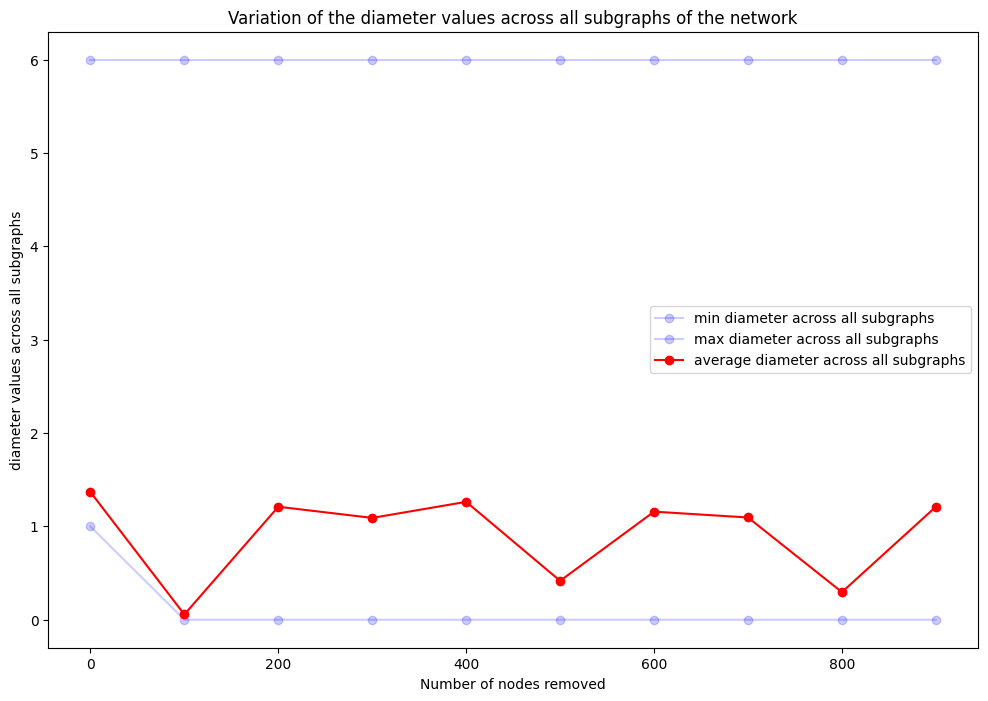

In [13]:
robustness()

In [14]:
# degree_centrality, between_centrality, close_centrality, eigen_centrality, _ = compute_centrality(G)

# max_degree_centrality = max(degree_centrality, key=degree_centrality.get)
# max_between_centrality = max(between_centrality, key=between_centrality.get)
# max_close_centrality = max(close_centrality, key=close_centrality.get)
# max_eigen_centrality = max(eigen_centrality, key=eigen_centrality.get)

In [15]:
# num_nodes = len(list(G.nodes()))

# diameter_list_min = []
# diameter_list_max = []
# diameter_list_average = []
# num_of_sugraphs_list = []

# removed_nodes = [0]

# list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

# nodes_to_be_deleted = 100

# rem_counter  = 0 

# for x in range (int(num_nodes/nodes_to_be_deleted)):

#     if x == 0:
#         list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

#         num_of_sugraphs_list.append(len(list_sub_graphs))
#         diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
#         diameter_list_min.append(min(diameters))
#         diameter_list_max.append(max(diameters))
#         diameter_list_average.append(sum(diameters)/len(diameters))
#         #nodes_exist.append(len(list(G.nodes())))
    

#     G_new = remove_node_randomly(G, nodes_to_be_deleted)
#     rem_counter = rem_counter + 100
    
#     list_sub_graphs = list(G_new.subgraph(c) for c in nx.connected_components(G_new))

#     num_of_sugraphs_list.append(len(list_sub_graphs))
#     diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
#     diameter_list_min.append(min(diameters))
#     diameter_list_max.append(max(diameters))
#     diameter_list_average.append(sum(diameters)/len(diameters))
#     #nodes_exist.append(len(list(G_new.nodes())))
#     rem_counter 
#     removed_nodes.append(rem_counter)

#     plt.figure(figsize=(12,8))
#     plt.title("Variation of the diameter values across all subgraphs of the network")
#     plt.xlabel("Number of nodes removed")
#     plt.ylabel("diameter values across all subgraphs")
#     plt.plot(removed_nodes, diameter_list_min, linestyle="-", marker="o", label="min diameter across all subgraphs", color="blue", alpha=0.2)
#     plt.plot(removed_nodes, diameter_list_max, linestyle="-", marker="o", label="max diameter across all subgraphs", color="blue", alpha=0.2)
#     plt.plot(removed_nodes, diameter_list_average, linestyle="-", marker="o", label="average diameter across all subgraphs", color="red")
#     plt.legend()
#     plt.show()
    

In [16]:
# num_of_sugraphs_list

In [17]:
# removed_nodes

In [18]:
# print(diameter_list_min)
# print(diameter_list_max)
# print(diameter_list_average)


In [19]:
# plt.figure(figsize=(12,8))
# plt.title("Variation of the diameter values across all subgraphs of the network")
# plt.xlabel("Number of nodes removed")
# plt.ylabel("diameter values across all subgraphs")
# plt.plot(removed_nodes, diameter_list_min, linestyle="-", marker="o", label="min diameter across all subgraphs", color="blue", alpha=0.2)
# plt.plot(removed_nodes, diameter_list_max, linestyle="-", marker="o", label="max diameter across all subgraphs", color="blue", alpha=0.2)
# plt.plot(removed_nodes, diameter_list_average, linestyle="-", marker="o", label="average diameter across all subgraphs", color="red")
# plt.legend()
# plt.show()